# Question 2

## (a) Design an auto encoder to take in MNIST images with latent space dimension of 2,16,256. 

- Train auto encoder with L1-norm reconstruction loss 

- Do a 2D plot of the latent space for different digits for latent space of 2D. 

- K-means clustering for latent space of dimensions 16,256. 

- Use one color for each digit. 

- Report all results. 
- What do you notice about the reconstructed images? 

In [40]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.manifold import TSNE
from torchsummary import summary
import skimage

In [41]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [42]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [43]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [44]:
def train(autoencoder, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = (abs(x - x_hat)).sum()  #L1 norm
            loss.backward()
            opt.step()
    return autoencoder

In [45]:
def plot_latent_2(autoencoder, data, num_batches=100):
    z_val = []
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x)
        z = z.detach().numpy()
        z_val.append(zip(z,y))
        if i > num_batches:
            # return z_val
            break

    z_val_2 = z_val # find_latent_2(autoencoder, data)
    X_mat_2, y_act_2 = [], []
    for i in z_val_2:
      for a, b in i:
        X_mat_2.append(a)
        y_act_2.append(b.item())

    plt.scatter(np.array(X_mat_2)[:, 0], 
                np.array(X_mat_2)[:, 1], 
                s=.1, c=y_act_2)

In [46]:
def plot_latent(autoencoder, data, num_batches=100):
    z_val = []
    for i, (x, y) in enumerate(data):
        # z = torch.flatten(x, start_dim=1)
        # z = autoencoder.encoder.linear1(z)
        # z = autoencoder.encoder.linear2(z)
        z = autoencoder.encoder(x)
        z = z.detach().numpy()
        z_val.append(zip(z,y))
        if i > num_batches:
            #return z_val
            break

    # z_val = plot_latent(autoencoder, data, num_batches=100)
    X_mat, y_act = [], []
    for i in z_val:
      for a, b in i:
        X_mat.append(a)
        y_act.append(b.item())
    
    # T-SNE transformation
    X_mat_TSNE = TSNE(n_components=2).fit_transform(X_mat)

    # plot actual results
    plt.figure()
    plt.scatter(X_mat_TSNE[:, 0], 
                X_mat_TSNE[:, 1], 
                s=.1, c=y_act)
    plt.title('actual')
    plt.show()

    return X_mat_TSNE

def plot_latent_kmeans(X_mat_TSNE):
    # k-means clustering
    kmeans = KMeans(n_clusters=10)
    kmeans.fit(X_mat_TSNE)
    y_kmeans = kmeans.predict(X_mat_TSNE)
    # plot k-means results
    plt.figure()
    plt.scatter(X_mat_TSNE[:, 0], 
                X_mat_TSNE[:, 1], 
                s=.1, c=y_kmeans)
    plt.title('K-means')
    plt.show()

In [51]:
def plot_reconstructed(autoencoder, latent_vectors):
    w = 28
    n = 12
    img = np.zeros((n*w, n*w))
    for i in range(n):
        for j in range(n):
            z = torch.Tensor(latent_vectors[i*n+j].tolist())
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[-5,10, -5, 10])


latent_vectors_2 = np.random.uniform(-5, 10,[1444,2])
latent_vectors_16 =  np.random.uniform(-5, 10,[144,16])
latent_vectors_256 =  np.random.uniform(-5, 10,[144,256])

### dim = 2

In [47]:
autoencoder_2 = Autoencoder(2)
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True),
        batch_size=128,
        shuffle=True)
autoencoder_2 = train(autoencoder_2, data)

In [ ]:
autoencoder_2

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [ ]:
# https://www.codenong.com/cs109184484/
def to_img(x):
    x = (x + 1.) * 0.5
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

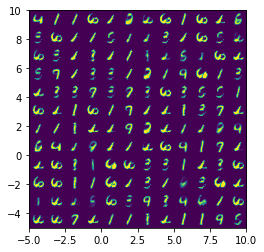

In [53]:
plot_reconstructed(autoencoder_2, latent_vectors_2)

/Users/leo/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/leo/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


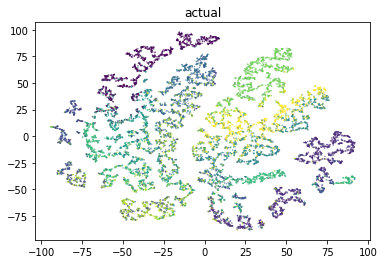

In [54]:
X_mat_TSNE_2 = plot_latent(autoencoder_2, data, num_batches=100)

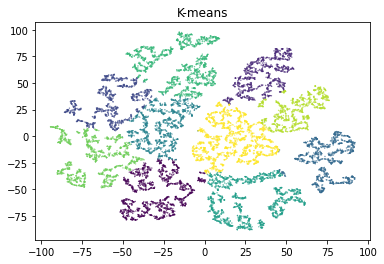

In [55]:
plot_latent_kmeans(X_mat_TSNE_2)

### dim = 16

In [56]:
autoencoder_16 = Autoencoder(16)
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True),
        batch_size=128,
        shuffle=True)
autoencoder_16 = train(autoencoder_16, data)

In [57]:
autoencoder_16

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=16, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)

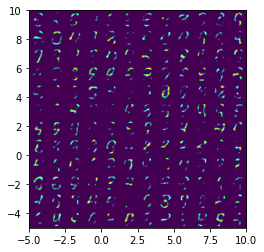

In [58]:
plot_reconstructed(autoencoder_16, latent_vectors_16)

/Users/leo/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/leo/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


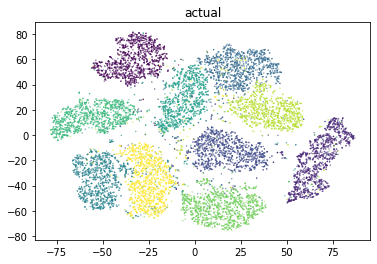

In [59]:
X_mat_TSNE_16 = plot_latent(autoencoder_16, data, num_batches=100)

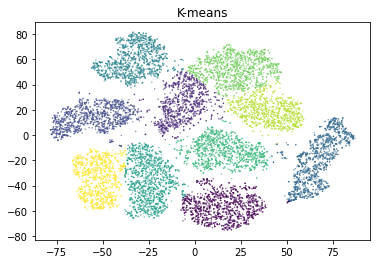

In [60]:
plot_latent_kmeans(X_mat_TSNE_16)

### dim = 256

In [61]:
autoencoder_256 = Autoencoder(256)
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True),
        batch_size=128,
        shuffle=True)
autoencoder_256 = train(autoencoder_256, data)

In [62]:
autoencoder_256

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=256, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)

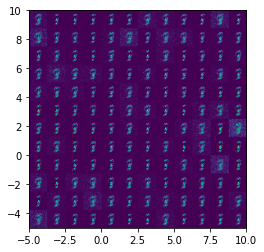

In [63]:
plot_reconstructed(autoencoder_256, latent_vectors_256)

/Users/leo/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/leo/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


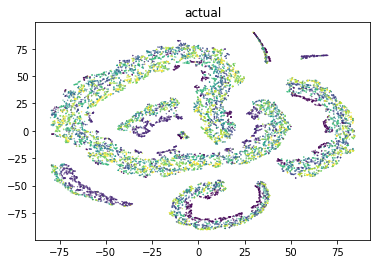

In [64]:
X_mat_TSNE_256 = plot_latent(autoencoder_256, data, num_batches=100)

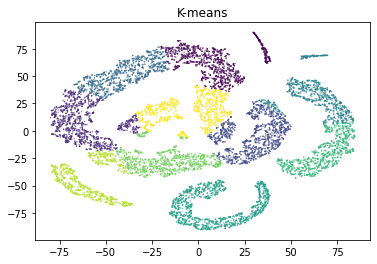

In [65]:
plot_latent_kmeans(X_mat_TSNE_256)

## (b) Design another neural network “dis_net” to discriminate between blur images and clear images. Blur images can be generated by taking the original MNIST data and do some gaussian blur.
Train auto encoder with L1-norm reconstruction loss + discriminator loss. Make reconstructed images as clear as possible, that is, the auto encoder will need to be trained so that “dis_net” score it as a clear image
Compare results between (a) and (b)

In [66]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.sigmoid(self.linear3(x))
        return x

In [67]:
def add_gaussian(images,sigma=1.0):
    blurred_images = np.zeros(images.shape)
    for i in range(images.shape[0]):
        blurred_images[i,0] = blurred = skimage.filters.gaussian(
    images[i], sigma=(sigma, sigma), truncate=3.5, multichannel=True)
    
    return blurred_images

In [68]:
def train_ae_dis(autoencoder, discriminator, data, epochs=10):
    ae_opt = torch.optim.Adam(autoencoder.parameters())
    dis_opt =   torch.optim.Adam(discriminator.parameters()) 
    for epoch in range(epochs):
        print("training epoch", epoch+1)
        for x, y in data:
            ae_opt.zero_grad()
            dis_opt.zero_grad()
            
            # train discriminator
            x_numpy = x.detach().numpy()
            blur_x = add_gaussian(x_numpy) 
            dis_x = np.concatenate([x_numpy,blur_x], axis =0)
            dis_y_one = np.ones([x.shape[0],1])
            dis_y_zero = np.zeros([x.shape[0],1])
            dis_y_target = np.concatenate([dis_y_one, dis_y_zero])
            dis_y_pred = discriminator(torch.from_numpy(dis_x).float())
        
            dis_loss = nn.BCELoss()(dis_y_pred, torch.from_numpy(dis_y_target).float())
            dis_loss.backward()
            dis_opt.step()
            
            #train ae
            x_hat = autoencoder(x)
            x_hat_pred = discriminator(x_hat)
            dis_loss = nn.BCELoss()(x_hat_pred, torch.from_numpy(np.ones([x_hat.shape[0],1])).float())
            loss = (abs(x - x_hat)).sum() + dis_loss  #L1 norm
            loss.backward()
            ae_opt.step()
    return autoencoder

In [69]:
autoencoder_2 = Autoencoder(2)
discriminator = Discriminator()
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True),
        batch_size=128,
        shuffle=True)
autoencoder_2 = train_ae_dis(autoencoder_2, discriminator, data)

training epoch 1


/var/folders/d6/j05xvvx54x5gz8vbr2mfnk940000gn/T/ipykernel_1445/235984247.py:4: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0.Please use `channel_axis` instead.
  blurred_images[i,0] = blurred = skimage.filters.gaussian(
/Users/leo/Library/Python/3.8/lib/python/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


training epoch 2
training epoch 3
training epoch 4
training epoch 5
training epoch 6
training epoch 7
training epoch 8
training epoch 9
training epoch 10


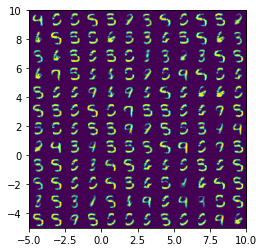

In [70]:
plot_reconstructed(autoencoder_2, latent_vectors_2)

/Users/leo/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/leo/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


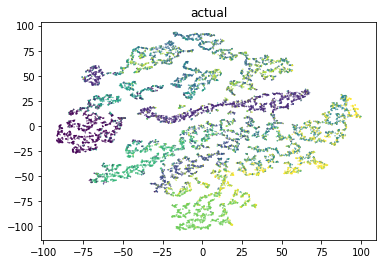

In [71]:
X_mat_TSNE_2 = plot_latent(autoencoder_2, data, num_batches=100)

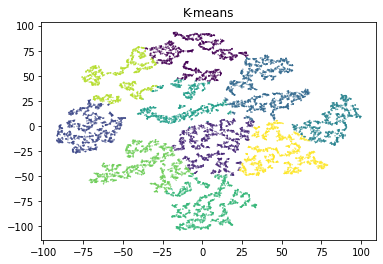

In [72]:
plot_latent_kmeans(X_mat_TSNE_2)

In [73]:
autoencoder_16 = Autoencoder(16)
discriminator = Discriminator()
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True),
        batch_size=128,
        shuffle=True)
autoencoder_16 = train_ae_dis(autoencoder_16, discriminator, data)

training epoch 1


/var/folders/d6/j05xvvx54x5gz8vbr2mfnk940000gn/T/ipykernel_1445/235984247.py:4: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0.Please use `channel_axis` instead.
  blurred_images[i,0] = blurred = skimage.filters.gaussian(
/Users/leo/Library/Python/3.8/lib/python/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


training epoch 2
training epoch 3
training epoch 4
training epoch 5
training epoch 6
training epoch 7
training epoch 8
training epoch 9
training epoch 10


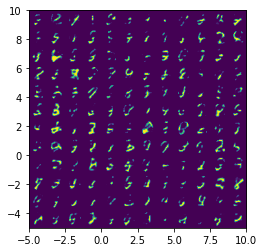

In [74]:
plot_reconstructed(autoencoder_16, latent_vectors_16)

/Users/leo/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/leo/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


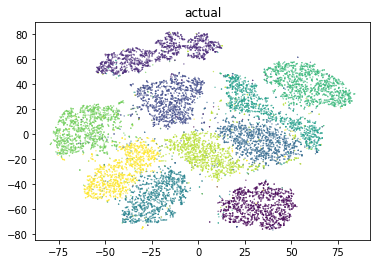

In [75]:
X_mat_TSNE_16 = plot_latent(autoencoder_16, data, num_batches=100)

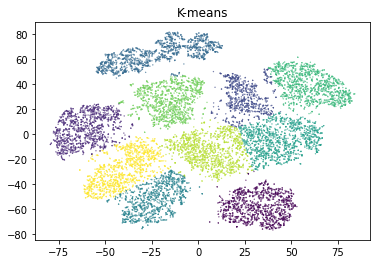

In [76]:
plot_latent_kmeans(X_mat_TSNE_16)

In [77]:
autoencoder_256 = Autoencoder(256)
discriminator = Discriminator()
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True),
        batch_size=128,
        shuffle=True)
autoencoder_256 = train_ae_dis(autoencoder_256, discriminator, data)

training epoch 1


/var/folders/d6/j05xvvx54x5gz8vbr2mfnk940000gn/T/ipykernel_1445/235984247.py:4: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0.Please use `channel_axis` instead.
  blurred_images[i,0] = blurred = skimage.filters.gaussian(
/Users/leo/Library/Python/3.8/lib/python/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


training epoch 2
training epoch 3
training epoch 4
training epoch 5
training epoch 6
training epoch 7
training epoch 8
training epoch 9
training epoch 10


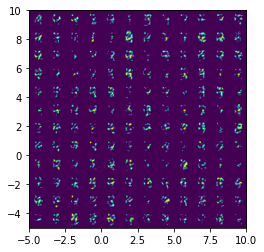

In [78]:
plot_reconstructed(autoencoder_256, latent_vectors_256)

/Users/leo/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/leo/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


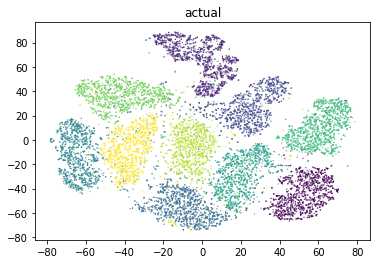

In [79]:
X_mat_TSNE_256 = plot_latent(autoencoder_256, data, num_batches=100)

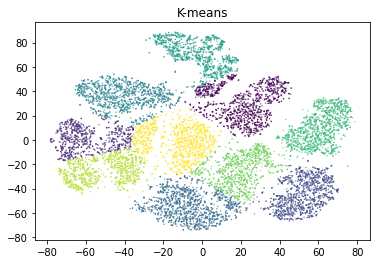

In [80]:
plot_latent_kmeans(X_mat_TSNE_256)